<a href="https://colab.research.google.com/github/Jyothirmai0564/EYAmcm9K4nFXaz4S/blob/main/bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Smart Bitcoin Trading System**

### **Overview**: We are building an autonomous, **AI-assisted cryptocurrency trading system** focused on Bitcoin. The system is designed to operate with minimal human supervision, run continuously in the cloud, and dynamically adapt to volatile market conditions.

Key goals:
1. Automate 24/7 Bitcoin trading
2. Balance **Dollar-Cost Averaging (DCA)** with **ATR-based stop-loss strategies**
3. Integrate **LLM-driven adaptability** for opportunistic trades and strategy selection
4. Ensure robust monitoring, security, and reporting

This system bridges **algorithmic trading, machine learning, and automation** to achieve long-term portfolio growth while minimizing risk.

### Project Objectives:
1. **Configurable Budget** - Accept user-defined budgets (e.g., $1K, $10K, $100K).
2. **DCA Strategy** - Buy Bitcoin incrementally at intervals or when prices drop.
3. **ATR Stop-Loss** - Use Average True Range (ATR) to set dynamic stop-loss thresholds.
4. **Hybrid Strategy Switching** - Support day trading, swing trading, and value investing.
5. **Continuous Adaptation** - Use a lightweight LLM to adjust strategies/features dynamically.
6. **Always-On Deployment** - Operate 24/7 in a cloud environment (AWS/DigitalOcean).
7. **Notifications & Reports** -
    * Telegram alerts for every trade
    * Weekly Gmail summary every Monday at 9:00 AM

# Bitcoin Trading Strategy Rulebook

## 📋 Overview
This Python script implements an automated trading strategy for Bitcoin (BTC-USD) using hourly price data. The strategy combines technical indicators with risk management rules to execute buy/sell decisions.

## 🎯 Strategy Components

### **Technical Indicators Used**
1. **Moving Averages**
   - SMA 20, 50, 90, 200 (Simple Moving Averages)
   - EMA 12, 26 (Exponential Moving Averages for MACD)

2. **Momentum Indicators**
   - RSI 14 (Relative Strength Index)
   - MACD (Moving Average Convergence Divergence)
   - Momentum 10 (Price difference over 10 periods)

3. **Volatility Indicators**
   - ATR 14 (Average True Range)
   - ADX 14 (Average Directional Index - optional)

4. **Trend Analysis**
   - Market Condition (Bullish/Bearish/Neutral) based on SMA50 vs SMA200

### **Trading Signals & Logic**

#### **Priority-Based Signal Generation**
1. **STRONG Signals** (Highest Priority - 10% allocation)
   - `STRONG_BUY`: RSI < 30 AND SMA50 > SMA200 (Oversold in uptrend)
   - `STRONG_SELL`: RSI > 70 AND SMA50 < SMA200 (Overbought in downtrend)

2. **RSI-Only Signals** (Medium Priority - 5% allocation)
   - `BUY`: RSI < 30 (Oversold condition)
   - `SELL`: RSI > 70 (Overbought condition)

3. **SMA-Only Signals** (Lowest Priority - 5% allocation)
   - `BUY`: SMA50 > SMA200 (Golden Cross - Bullish trend)
   - `SELL`: SMA50 < SMA200 (Death Cross - Bearish trend)

#### **Risk Management Features**
- **DCA (Dollar-Cost Averaging)**
  - `DCA_BUY`: 5% drop from STRONG_BUY entry price (5% allocation)
  - `DCA_SELL`: 10% drop from STRONG_BUY entry price (1% allocation)

- **Stop-Loss Protection**
  - `ATR_STOPLOSS`: Price drops below (entry_price - 2*ATR)

### **💰 Position & Money Management**
- **Initial Capital**: $100,000
- **Minimum Trade**: $10 (prevents micro-transactions)
- **Position Sizing**: Percentage-based (5% or 10% of available cash/holdings)
- **Cost Tracking**: Maintains average cost basis for profit calculation

## 📊 Data Processing

### **Data Source**
- **Provider**: Yahoo Finance (yfinance)
- **Symbol**: BTC-USD
- **Period**: 180 days (6 months)
- **Interval**: 1-hour candles

### **Data Columns Processed**
- Datetime, Open, High, Low, Close, Volume
- All calculated technical indicators
- Trading signals and execution details

## 📈 Output Files

### **1. Trading Details CSV**
Contains hourly records of:
- Price and indicator values
- Generated signals and reasons
- Portfolio state (cash, BTC holdings, position cost)
- Trade execution status

### **2. Transactions CSV**
Records only executed trades with:
- Timestamp and trade type
- Price, quantity, and amount
- Remaining cash and BTC holdings
- Realized profit and signal reason

## ⚙️ Configuration Parameters

| Parameter | Value | Description |
|-----------|-------|-------------|
| `SYMBOL` | BTC-USD | Trading instrument |
| `PERIOD_DAYS` | 180 | Data history length |
| `INTERVAL` | 1h | Candle timeframe |
| `INITIAL_CASH` | 100,000 | Starting capital |
| `MIN_TRADE_USD` | 10 | Minimum trade size |
| `ATR_MULTIPLIER` | 2.0 | Stop-loss multiplier |
| `DCA_DROP_PCT_1` | 0.95 | 5% drop trigger |
| `DCA_DROP_PCT_2` | 0.90 | 10% drop trigger |

## 🔄 Execution Flow
1. **Data Fetching** → Get BTC hourly data from Yahoo Finance
2. **Indicator Calculation** → Compute all technical indicators
3. **Signal Generation** → Apply priority-based trading rules
4. **Trade Execution** → Execute buys/sells with risk management
5. **Results Export** → Save detailed logs and summary

## 🎲 Strategy Philosophy
- **Trend Following**: Uses moving averages for trend identification
- **Mean Reversion**: Uses RSI for overbought/oversold conditions
- **Risk Management**: Implements DCA and stop-loss protection
- **Systematic Approach**: Removes emotional decision making


**Config/Parameters**

In [32]:

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import os

# CONFIG
SYMBOL = "BTC-USD"
PERIOD_DAYS = 180
INTERVAL = "1h"
INITIAL_CASH = 100000
MIN_TRADE_USD = 10
ATR_MULTIPLIER = 2.0
DCA_DROP_PCT_1 = 0.95
DCA_DROP_PCT_2 = 0.90

Preparing historical price data (like Bitcoin) using Yahoo Finance (yfinance) by creating a Yahoo Finance ticker object. Some Yahoo Finance intervals name the time column as "Date", while others use "Datetime".To avoid confusion later, we standardize the name.

✅ This makes sure every dataset uses "Datetime" consistently. And keeping only what’s needed for trading/backtesting.

**Fetching data and preparing data**

In [33]:
ticker = yf.Ticker(SYMBOL)
df = ticker.history(period=f"{PERIOD_DAYS}d", interval=INTERVAL).reset_index()

# Ensure consistency
if "Datetime" not in df.columns and "Date" in df.columns:
    df.rename(columns={"Date": "Datetime"}, inplace=True)

df = df[["Datetime", "Open", "High", "Low", "Close", "Volume"]]
df.sort_values("Datetime", inplace=True)
df.reset_index(drop=True, inplace=True)

print("✅ Data Loaded and Standardized!")

✅ Data Loaded and Standardized!


**Technical Indicators used:**

In [34]:
!pip install ta --quiet

In [35]:
import ta
# Simple Moving Averages
df["SMA_20"] = df["Close"].rolling(window=20).mean()
df["SMA_50"] = df["Close"].rolling(window=50).mean()
df["SMA_200"] = df["Close"].rolling(window=200).mean()

# Exponential Moving Averages + MACD
df["EMA_12"] = df["Close"].ewm(span=12, adjust=False).mean()
df["EMA_26"] = df["Close"].ewm(span=26, adjust=False).mean()
df["MACD"] = df["EMA_12"] - df["EMA_26"]
df["MACD_Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()

df["RSI_14"] = ta.momentum.RSIIndicator(df["Close"], window=14).rsi()
macd = ta.trend.MACD(df["Close"])


df["STD_20"] = df["Close"].rolling(20).std()
df["Upper"] = df["SMA_20"] + 2 * df["STD_20"]
df["Lower"] = df["SMA_20"] - 2 * df["STD_20"]


# RSI (Relative Strength Index)
delta = df["Close"].diff()
up = delta.clip(lower=0)
down = -delta.clip(upper=0)
roll_up = up.ewm(alpha=1/14, adjust=False).mean()
roll_down = down.ewm(alpha=1/14, adjust=False).mean()
rs = roll_up / roll_down
df["RSI_14"] = 100 - (100 / (1 + rs))

# ATR (Average True Range)
high_low = df["High"] - df["Low"]
high_prev_close = (df["High"] - df["Close"].shift()).abs()
low_prev_close = (df["Low"] - df["Close"].shift()).abs()
tr = pd.concat([high_low, high_prev_close, low_prev_close], axis=1).max(axis=1)
df["ATR_14"] = tr.ewm(alpha=1/14, adjust=False).mean()

# Market Condition
df["Market_Condition"] = np.where(df["SMA_50"] > df["SMA_200"], "BULLISH",
                          np.where(df["SMA_50"] < df["SMA_200"], "BEARISH", "UNKNOWN"))

df.dropna(subset=["SMA_50", "SMA_200", "RSI_14", "ATR_14"], inplace=True)
df.reset_index(drop=True, inplace=True)

print("✅ Indicators calculated!")
df.head()

✅ Indicators calculated!


,Datetime,Open,High,Low,Close,Volume,SMA_20,SMA_50,SMA_200,EMA_12,EMA_26,MACD,MACD_Signal,RSI_14,STD_20,Upper,Lower,ATR_14,Market_Condition
0,2025-05-09 07:00:00+00:00,103210.140625,104178.117188,103151.671875,103727.406250,2758832128,101931.533594,99404.970937,96597.776406,102644.546075,101483.135040,1161.411036,1184.261229,75.051366,1373.170221,104677.874036,99185.193152,616.355930,BULLISH
1,2025-05-09 08:00:00+00:00,103704.460938,103875.164062,102782.164062,102924.234375,2497691648,102112.394922,99532.455625,96640.536133,102687.575045,101589.883139,1097.691906,1166.947364,63.963560,1241.167437,104594.729796,99630.060048,650.401935,BULLISH
2,2025-05-09 09:00:00+00:00,102988.789062,103217.148438,102480.710938,102919.921875,936583168,102293.723437,99650.384063,96682.081641,102723.320711,101688.404527,1034.916184,1140.541128,63.908965,1059.218412,104412.160261,100175.286614,656.547333,BULLISH
3,2025-05-09 10:00:00+00:00,102918.906250,103418.437500,102867.257812,103404.546875,881270784,102489.236719,99778.284375,96724.938516,102828.124736,101815.526182,1012.598554,1114.952613,67.287981,856.844656,104202.926030,100775.547408,649.021072,BULLISH
4,2025-05-09 11:00:00+00:00,103280.796875,103402.242188,102872.226562,103010.375000,2010357760,102597.609375,99899.082187,96766.047031,102856.163238,101904.033502,952.129736,1082.388038,62.188071,770.366024,104138.341423,101056.877327,640.685304,BULLISH


| Indicator          | Type           | Purpose                                              | Interpretation                             |
| ------------------ | -------------- | ---------------------------------------------------- | ------------------------------------------ |
| SMA_20 / 50 / 200  | Trend          | Detects short, medium, and long-term trend direction | Crossovers indicate bullish/bearish shifts |
| EMA_12 / 26        | Trend/Momentum | Reacts faster to price changes                       | Used to calculate MACD                     |
| MACD / MACD_Signal | Momentum       | Measures strength and direction of momentum          | MACD > Signal → bullish                    |
| Momentum_10        | Momentum       | Measures speed of price change                       | +ve rising / -ve falling                   |
| RSI_14             | Momentum       | Detects overbought/oversold levels                   | >70 overbought / <30 oversold              |
| ATR_14             | Volatility     | Measures price movement range                        | High ATR = volatile market                 |
| Market_Condition   | Label          | Classifies overall trend                             | Bullish / Bearish                          |


**Prepare for Backtest: cleanup & initialize state**

Sets up the initial trading state (cash, holdings, profit.) and then iterates through each time-step (usually hourly) in the Bitcoin price data to prepare for trading decisions.

**Signal logic & trade execution loop**

Trading loop, which processes Bitcoin price data hour by hour to decide when to buy, sell, or hold. It begins by initializing the trading state — starting with a given amount of cash (INITIAL_CASH), no BTC holdings (btc_holdings = 0.0), no open position cost (position_cost = 0.0), and zero realized profit (realized_profit = 0.0). The variable last_strong_buy_price is used to track the price at which the most recent strong buy signal occurred, helping the strategy avoid repeated entries at similar levels or trigger DCA (Dollar-Cost Averaging) buys when the price drops further. Two lists are then created: trading_details, which will record the trading status for every hour (price, indicators, holdings, etc.), and transactions, which will log only the actual trades (buy/sell actions).

This block of code defines the core signal generation logic — the decision-making engine of the trading strategy. It determines whether to buy, sell, or hold Bitcoin based on a combination of technical indicators: the Relative Strength Index (RSI) for momentum, and the Simple Moving Averages (SMA 50 and SMA 200) for trend direction. The code prioritizes trading signals into three levels: Strong Signals, RSI-only signals, and SMA-only signals, ensuring that high-confidence opportunities are acted upon first.

| Priority   | Signal Type        | Indicators Used             | Example Action | Capital Used |
| ---------- | ------------------ | --------------------------- | -------------- | ------------ |
| 1️⃣ High   | **Strong Signals** | RSI + SMA (trend confirmed) | Buy/Sell       | 10%          |
| 2️⃣ Medium | **RSI-Only**       | RSI (momentum only)         | Buy/Sell       | 5%           |
| 3️⃣ Low    | **SMA-Only**       | SMA50 vs SMA200 (trend)     | Buy/Sell       | 5%           |


Risk management and position adjustment logic to the trading system, focusing on how to react after a strong buy signal has been made. It uses the last strong entry price (last_strong_buy_price), price drops, and market volatility (measured by ATR — Average True Range) to make Dollar-Cost Averaging (DCA) and stop-loss decisions.First, the code checks if a previous strong buy entry exists (last_strong_buy_price) and ensures that both it and the ATR value are valid (not missing). Then it evaluates three conditions that determine how the trader should respond if the price falls below certain thresholds after a strong buy:

| Condition Type         | Trigger Condition                                              | Action | Percent | Reason                                      | Purpose                                                                                  |
|-------------------------|---------------------------------------------------------------|---------|----------|---------------------------------------------|------------------------------------------------------------------------------------------|
| **5% Drop — DCA Buy**   | `price <= last_strong_buy_price * DCA_DROP_PCT_1`             | BUY     | 5% of cash | Price dropped 5% from STRONG_BUY entry      | Average down entry price and use dip opportunities (Dollar-Cost Averaging principle).     |
| **10% Drop — DCA Sell** | `price <= last_strong_buy_price * DCA_DROP_PCT_2`             | SELL    | 1% of holdings | Price dropped 10% from STRONG_BUY entry | Slightly reduce exposure and protect capital during stronger downtrend.                  |
| **ATR Stop-Loss**       | `price <= last_strong_buy_price - ATR_MULTIPLIER * atr`       | SELL    | 5% of holdings | ATR stop-loss triggered (e.g., 2 * ATR) | Adaptive stop-loss based on volatility; exits when price moves beyond normal variation.  |


buy and sell trades based on the signals generated earlier and updates the trading state accordingly. It ensures that all trades respect minimum trade sizes (MIN_TRADE_USD) and properly track cash, Bitcoin holdings, position cost, and realized profits.

When the action is "BUY", the code calculates the USD amount to invest (invest_usd) as a percentage of the available cash defined by the signal. If this amount meets or exceeds the minimum trade threshold, it computes how much BTC to buy (trade_qty = invest_usd / price) and updates the portfolio: increasing btc_holdings, reducing cash, and adding the invested amount to position_cost. The trade_executed flag is set to True, indicating a trade occurred. If the buy signal is "STRONG_BUY", the last_strong_buy_price is updated to the current price to track for future DCA or stop-loss decisions. Finally, all details of the trade — timestamp, action, signal type, price, quantity, USD amount, cash remaining, BTC holdings, cumulative realized profit, and reason — are appended to the transactions list for logging and later analysis.

For the "SELL" action, the code calculates the quantity of BTC to sell as a percentage of current holdings, ensuring it does not exceed total holdings. It checks that the trade meets the minimum USD threshold and is positive. The average cost of the holdings is calculated (avg_cost = position_cost / btc_holdings) to determine the realized profit from this sale, which is added to the cumulative realized_profit. The portfolio is updated: btc_holdings is reduced, cash is increased by the trade amount, and position_cost is reduced proportionally. If selling empties the BTC position, last_strong_buy_price and position_cost are reset to zero. As with buys, all trade details are appended to the transactions list.

In essence, this code ensures accurate portfolio accounting, enforces minimum trade sizes, tracks realized profit for performance measurement, and maintains proper state for future trade decisions, making it the core execution engine of the backtesting system

In [36]:
# ---------------- INITIALIZE STRATEGIES ----------------
strategies = {
    "SimpleSMA": {"cash": INITIAL_CASH, "btc": 0.0, "cost": 0.0, "profit": 0.0},
    "BuyHold": {"cash": INITIAL_CASH, "btc": 0.0, "cost": 0.0, "profit": 0.0, "invested": False},
    "SMACrossover": {"cash": INITIAL_CASH, "btc": 0.0, "cost": 0.0, "profit": 0.0},
    "EMATrend": {"cash": INITIAL_CASH, "btc": 0.0, "cost": 0.0, "profit": 0.0},
    "RSIMomentum": {"cash": INITIAL_CASH, "btc": 0.0, "cost": 0.0, "profit": 0.0},
    "BearishDefense": {"cash": INITIAL_CASH, "btc": 0.0, "cost": 0.0, "profit": 0.0}
}

trading_details = []
transactions = []


# Helper function to log transactions
def log_tx(timestamp, strategy_name, action, signal, price, qty, trade_amt, cash_left, btc_holdings, realized_profit, reason):
    transactions.append({
        "Timestamp": timestamp,
        "Strategy": strategy_name,
        "Action": action,
        "Signal": signal,
        "Price": price,
        "Quantity": qty,
        "Trade_Amount": trade_amt,
        "Cash_Left": cash_left,
        "BTC_Holdings": btc_holdings,
        "Realized_Profit": realized_profit,
        "Reason": reason
    })


# ---------------- BACKTEST LOOP ----------------
LOOKBACK_2W_HOURS = 14 * 24  # 336 hours

for idx, row in df.iterrows():
    timestamp = row["Datetime"]
    price = float(row["Close"])
    rsi = float(row["RSI_14"])
    sma20, sma50, sma200 = float(row["SMA_20"]), float(row["SMA_50"]), float(row["SMA_200"])
    ema12, ema26 = float(row["EMA_12"]), float(row["EMA_26"])
    atr = float(row["ATR_14"])

    strategy_values = {}

    for name, s in strategies.items():
        strat_signal = "HOLD"
        strat_action = None
        strat_percent = 0.0
        executed_qty = 0.0
        executed_amt = 0.0
        realized_profit = s.get("profit", 0.0)

        # ---------------- STRATEGY LOGIC ----------------
        if name == "SMACrossover":
            if sma50 > sma200:
                strat_signal, strat_action, strat_percent = "STRONG_BUY", "BUY", 10.0
            elif sma50 < sma200:
                strat_signal, strat_action, strat_percent = "STRONG_SELL", "SELL", 10.0

        elif name == "BuyHold":
            if not s.get("invested", False):
                strat_signal, strat_action, strat_percent = "BUY", "BUY", 100.0
                s["invested"] = True

        elif name == "SimpleSMA":
            if price > sma50 and s["cash"] > MIN_TRADE_USD:
                strat_signal, strat_action, strat_percent = "BUY", "BUY", 5.0
            elif price < sma50 and s["btc"] > 0:
                strat_signal, strat_action, strat_percent = "SELL", "SELL", 5.0

        elif name == "EMATrend":
            if ema12 > ema26 and s["cash"] > MIN_TRADE_USD:
                strat_signal, strat_action, strat_percent = "BUY", "BUY", 5.0
            elif ema12 < ema26 and s["btc"] > 0:
                strat_signal, strat_action, strat_percent = "SELL", "SELL", 5.0

        elif name == "RSIMomentum":
            if rsi > 60 and price > sma20:
                strat_signal, strat_action, strat_percent = "BUY", "BUY", 5.0
            elif rsi < 40 and price < sma20:
                strat_signal, strat_action, strat_percent = "SELL", "SELL", 5.0

        elif name == "BearishDefense":
            # Calculate recent price changes
            price_24h_ago = df["Close"].iloc[idx - 24] if idx >= 24 else price
            price_7d_ago = df["Close"].iloc[idx - (7 * 24)] if idx >= (7 * 24) else price

            price_change_24h = (price - price_24h_ago) / price_24h_ago
            price_change_7d = (price - price_7d_ago) / price_7d_ago

            # Multiple bearish signals with scoring system
            bearish_score = 0
            reasons = []

            # 1️⃣ RSI oversold for extended period (less strict)
            if idx >= LOOKBACK_2W_HOURS - 1:
                window_rsi = df["RSI_14"].iloc[idx - (LOOKBACK_2W_HOURS - 1): idx + 1]
                oversold_days = (window_rsi < 35).sum() / 24  # Convert hours to days
                if oversold_days >= 10:  # 10+ days of oversold
                    bearish_score += 2
                    reasons.append(f"RSI_oversold_{int(oversold_days)}days")

            # 2️⃣ Price below SMA200 with momentum
            if price < 0.92 * sma200:  # 8% below SMA200
                bearish_score += 2
                reasons.append("8%_below_SMA200")
            elif price < 0.95 * sma200:  # 5% below SMA200
                bearish_score += 1
                reasons.append("5%_below_SMA200")

            # 3️⃣ Significant weekly drop
            if price_change_7d <= -0.12:  # 12% weekly drop
                bearish_score += 2
                reasons.append(f"weekly_drop_{price_change_7d:.1%}")
            elif price_change_7d <= -0.08:  # 8% weekly drop
                bearish_score += 1
                reasons.append(f"weekly_drop_{price_change_7d:.1%}")

            # 4️⃣ Additional bearish confirmation
            if ema12 < ema26 and price < sma50:
                bearish_score += 1
                reasons.append("downtrend_confirmed")

            # --- Trading Logic ---
            # SELL if bearish score reaches threshold
            if bearish_score >= 3 and s["btc"] > 0:
                strat_signal = f"BEARISH_SELL_score{bearish_score}_{'_'.join(reasons)}"
                strat_action, strat_percent = "SELL", 25.0

            # BUY only when multiple bullish conditions met
            elif (price > sma50 and
                  ema12 > ema26 and
                  rsi > 45 and
                  price_change_24h > 0 and
                  s["btc"] == 0 and
                  s["cash"] > MIN_TRADE_USD):
                strat_signal, strat_action, strat_percent = "RECOVERY_BUY", "BUY", 100.0

            else:
                strat_signal = "HOLD"

        # ---------------- EXECUTE TRADE ----------------
        if strat_action == "BUY":
            to_invest = s["cash"] * (strat_percent / 100.0) if strat_percent > 0 else s["cash"]
            if to_invest >= MIN_TRADE_USD:
                qty = to_invest / price
                s["btc"] += qty
                s["cash"] -= to_invest
                s["cost"] += to_invest
                executed_qty = qty
                executed_amt = to_invest
                log_tx(timestamp, name, "BUY", strat_signal, price, executed_qty, executed_amt,
                       s["cash"], s["btc"], s.get("profit", 0.0), strat_signal)

        elif strat_action == "SELL":
            sell_qty = min(s["btc"], s["btc"] * (strat_percent / 100.0)) if strat_percent > 0 else s["btc"]
            if sell_qty > 0:
                avg_cost = (s["cost"] / s["btc"]) if s["btc"] > 0 else 0.0
                realized = sell_qty * (price - avg_cost)
                s["profit"] += realized
                s["cash"] += sell_qty * price
                s["cost"] -= avg_cost * sell_qty
                s["btc"] -= sell_qty
                executed_qty = sell_qty
                executed_amt = sell_qty * price
                log_tx(timestamp, name, "SELL", strat_signal, price, executed_qty, executed_amt,
                       s["cash"], s["btc"], s.get("profit", 0.0), strat_signal)

        # ---------------- UPDATE STRATEGY VALUE ----------------
        strat_value = s["cash"] + s["btc"] * price
        strategy_values[name] = {
            "value": strat_value,
            "cash": s["cash"],
            "btc": s["btc"],
            "cost": s["cost"],
            "profit": s["profit"]
        }

    # ---------------- HOURLY SNAPSHOT ----------------
    total_cash = sum(strategy_values[n]["cash"] for n in strategy_values)
    total_btc = sum(strategy_values[n]["btc"] for n in strategy_values)
    total_cost = sum(strategy_values[n]["cost"] for n in strategy_values)
    total_profit = sum(strategy_values[n]["profit"] for n in strategy_values)
    total_portfolio_value = total_cash + total_btc * price

    trading_details.append({
        "Timestamp": timestamp,
        "Price": price,
        "RSI_14": rsi,
        "SMA_50": sma50,
        "SMA_200": sma200,
        "ATR_14": atr,
        "Signal": "HOLD",
        "Action": None,
        "Percent": 0.0,
        "Cash": total_cash,
        "BTC_Holdings": total_btc,
        "Position_Cost": total_cost,
        "Portfolio_Value": total_portfolio_value,
        "Realized_Profit": total_profit,
        "Trade_Executed": False,
        "Trade_Qty": 0.0,
        "Trade_Amount": 0.0,
        "Trade_Realized_Profit": 0.0,
        "SimpleSMA_Value": strategy_values["SimpleSMA"]["value"],
        "BuyHold_Value": strategy_values["BuyHold"]["value"],
        "SMACrossover_Value": strategy_values["SMACrossover"]["value"],
        "EMATrend_Value": strategy_values["EMATrend"]["value"],
        "RSIMomentum_Value": strategy_values["RSIMomentum"]["value"],
        "BearishDefense_Value": strategy_values["BearishDefense"]["value"]
    })


# ---------------- SAVE CSVs ----------------
details_df = pd.DataFrame(trading_details)
transactions_df = pd.DataFrame(transactions)

details_df.to_csv("btc_hourly_details_jan_jun2020.csv", index=False)
transactions_df.to_csv("btc_hourly_transactions_jan_jun2020.csv", index=False)
df.to_csv("bitcoin_trading_backtest_complete_jan_jun2020.csv", index=False)

print("✅ Files saved successfully!")


✅ Files saved successfully!


In [37]:
import pandas as pd

def save_individual_strategy_csvs(df, transactions_df, trading_details_df):
    """
    Create individual CSV files for each strategy with correct indicators, trade data, and portfolio tracking.
    """

    # === Define indicators per strategy ===
    strategy_indicators = {
        "SimpleSMA": ["SMA_50"],
        "BuyHold": [],
        "SMACrossover": ["SMA_50", "SMA_200"],
        "EMATrend": ["EMA_12", "EMA_26"],
        "RSIMomentum": ["RSI_14", "SMA_20"],
        "BearishDefense": ["SMA_50", "RSI_14"]
    }

    # === Base columns to include ===
    base_cols = [
        "Datetime", "Open", "High", "Low",
        "Close",  # renamed later
        "Action", "Signal", "Cash_Left",
        "Portfolio_Value", "Trade_Executed",
        "Trade_Qty", "Trade_Amount", "Trade_Profit"
    ]

    # === Loop through each strategy ===
    for strat_name, indicators in strategy_indicators.items():
        strat_tx = transactions_df[transactions_df["Strategy"] == strat_name].copy()

        if strat_tx.empty:
            print(f"⚠️ No trades found for {strat_name}, skipping.")
            continue

        # Get per-hour portfolio values from trading_details_df
        strat_details = trading_details_df[[
            "Timestamp",
            f"{strat_name}_Value"
        ]].copy()
        strat_details.rename(columns={f"{strat_name}_Value": "Portfolio_Value"}, inplace=True)

        # Merge with indicators and trade info
        merged = pd.merge(df, strat_details, left_on="Datetime", right_on="Timestamp", how="left")
        merged = pd.merge(merged, strat_tx, on="Timestamp", how="left", suffixes=("", "_tx"))

        # Rename Close for clarity
        merged.rename(columns={"Close": "BTC_Price"}, inplace=True)

        # Fill missing fields safely
        merged["Action"] = merged["Action"].fillna("HOLD")
        merged["Signal"] = merged["Signal"].fillna("HOLD")
        merged["Trade_Executed"] = merged["Action"].ne("HOLD")
        merged["Trade_Qty"] = merged["Quantity"].fillna(0.0)
        merged["Trade_Amount"] = merged["Trade_Amount"].fillna(0.0)
        merged["Trade_Profit"] = merged["Realized_Profit"].fillna(0.0)
        merged["Cash_Left"] = merged["Cash_Left"].fillna(method="ffill").fillna(0.0)
        merged["Portfolio_Value"] = merged["Portfolio_Value"].fillna(method="ffill").fillna(0.0)

        # Select columns
        final_cols = [
            "Datetime", "Open", "High", "Low", "BTC_Price",
            "Action", "Signal", "Cash_Left", "Portfolio_Value",
            "Trade_Executed", "Trade_Qty", "Trade_Amount", "Trade_Profit"
        ] + indicators

        strat_final = merged[final_cols]

        # Save file
        filename = f"{strat_name}_Strategy.csv"
        strat_final.to_csv(filename, index=False)
        print(f"✅ Saved {filename} ({len(strat_final)} rows)")

# Example usage after backtesting loop:
details_df = pd.DataFrame(trading_details)
transactions_df = pd.DataFrame(transactions)

save_individual_strategy_csvs(df, transactions_df, details_df)


✅ Saved SimpleSMA_Strategy.csv (4112 rows)


/tmp/ipython-input-2877919750.py:56: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged["Cash_Left"] = merged["Cash_Left"].fillna(method="ffill").fillna(0.0)
/tmp/ipython-input-2877919750.py:57: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged["Portfolio_Value"] = merged["Portfolio_Value"].fillna(method="ffill").fillna(0.0)
/tmp/ipython-input-2877919750.py:56: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged["Cash_Left"] = merged["Cash_Left"].fillna(method="ffill").fillna(0.0)
/tmp/ipython-input-2877919750.py:57: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged["Portfolio_Value"] = merged["Portfolio_Value"].fillna(method="

✅ Saved BuyHold_Strategy.csv (4112 rows)
✅ Saved SMACrossover_Strategy.csv (4112 rows)
✅ Saved EMATrend_Strategy.csv (4112 rows)


/tmp/ipython-input-2877919750.py:56: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged["Cash_Left"] = merged["Cash_Left"].fillna(method="ffill").fillna(0.0)
/tmp/ipython-input-2877919750.py:57: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged["Portfolio_Value"] = merged["Portfolio_Value"].fillna(method="ffill").fillna(0.0)
/tmp/ipython-input-2877919750.py:56: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged["Cash_Left"] = merged["Cash_Left"].fillna(method="ffill").fillna(0.0)
/tmp/ipython-input-2877919750.py:57: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged["Portfolio_Value"] = merged["Portfolio_Value"].fillna(method="

✅ Saved RSIMomentum_Strategy.csv (4112 rows)
✅ Saved BearishDefense_Strategy.csv (4112 rows)


In [38]:
from google.colab import files

# Download all strategy CSVs one by one
files.download("SimpleSMA_Strategy.csv")
files.download("BuyHold_Strategy.csv")
files.download("SMACrossover_Strategy.csv")
files.download("EMATrend_Strategy.csv")
files.download("RSIMomentum_Strategy.csv")
files.download("BearishDefense_Strategy.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**🪙 BITCOIN STRATEGY ANALYSIS DASHBOARD**

In [39]:
import matplotlib.pyplot as plt

def plot_strategy(df, transactions_df, strategy_name):
    """
    Plots BTC price, indicators, buy/sell points, and portfolio value for a given strategy.
    """

    plt.style.use("dark_background")
    plt.figure(figsize=(14, 7))

    # Filter data for the specific strategy
    strat_tx = transactions_df[transactions_df["Strategy"] == strategy_name]
    if strat_tx.empty:
        print(f"⚠️ No trades found for {strategy_name}. Skipping plot.")
        return

    # Merge to align timestamps
    merged = pd.merge(df, strat_tx, left_on="Datetime", right_on="Timestamp", how="left")

    # Identify strategy-specific columns
    indicators = {
        "SimpleSMA": ["SMA_50"],
        "BuyHold": [],
        "SMACrossover": ["SMA_50", "SMA_200"],
        "EMATrend": ["EMA_12", "EMA_26"],
        "RSIMomentum": ["RSI_14", "SMA_20"],
        "BearishDefense": ["SMA_50", "RSI_14"]
    }.get(strategy_name, [])

    # --- Plot price line ---
    plt.plot(merged["Datetime"], merged["Close"], color="deepskyblue", label="BTC Price", linewidth=1.5)

    # --- Plot indicators ---
    colors = ["orange", "violet", "lightgreen"]
    for i, ind in enumerate(indicators):
        if ind in merged.columns:
            plt.plot(merged["Datetime"], merged[ind], color=colors[i % len(colors)], label=ind, linewidth=1)

    # --- Mark Buy/Sell points ---
    buy_points = merged[merged["Action"] == "BUY"]
    sell_points = merged[merged["Action"] == "SELL"]

    plt.scatter(buy_points["Datetime"], buy_points["Close"], color="lime", marker="^", s=100, label="Buy", zorder=5)
    plt.scatter(sell_points["Datetime"], sell_points["Close"], color="red", marker="v", s=100, label="Sell", zorder=5)

    # --- Portfolio Value as secondary axis ---
    ax = plt.gca()
    ax2 = ax.twinx()
    if "Portfolio_Value" in merged.columns:
        ax2.plot(merged["Datetime"], merged["Portfolio_Value"], color="gray", label="Portfolio Value", alpha=0.5)
        ax2.set_ylabel("Portfolio Value (USD)", color="gray")

    # --- Titles and labels ---
    plt.title(f"{strategy_name} Strategy — BTC/USD", fontsize=16, fontweight="bold")
    plt.xlabel("Date")
    plt.ylabel("BTC Price (USD)")
    ax.legend(loc="upper left", fontsize=10)
    ax2.legend(loc="upper right", fontsize=10)

    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-1865169091.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc="upper right", fontsize=10)


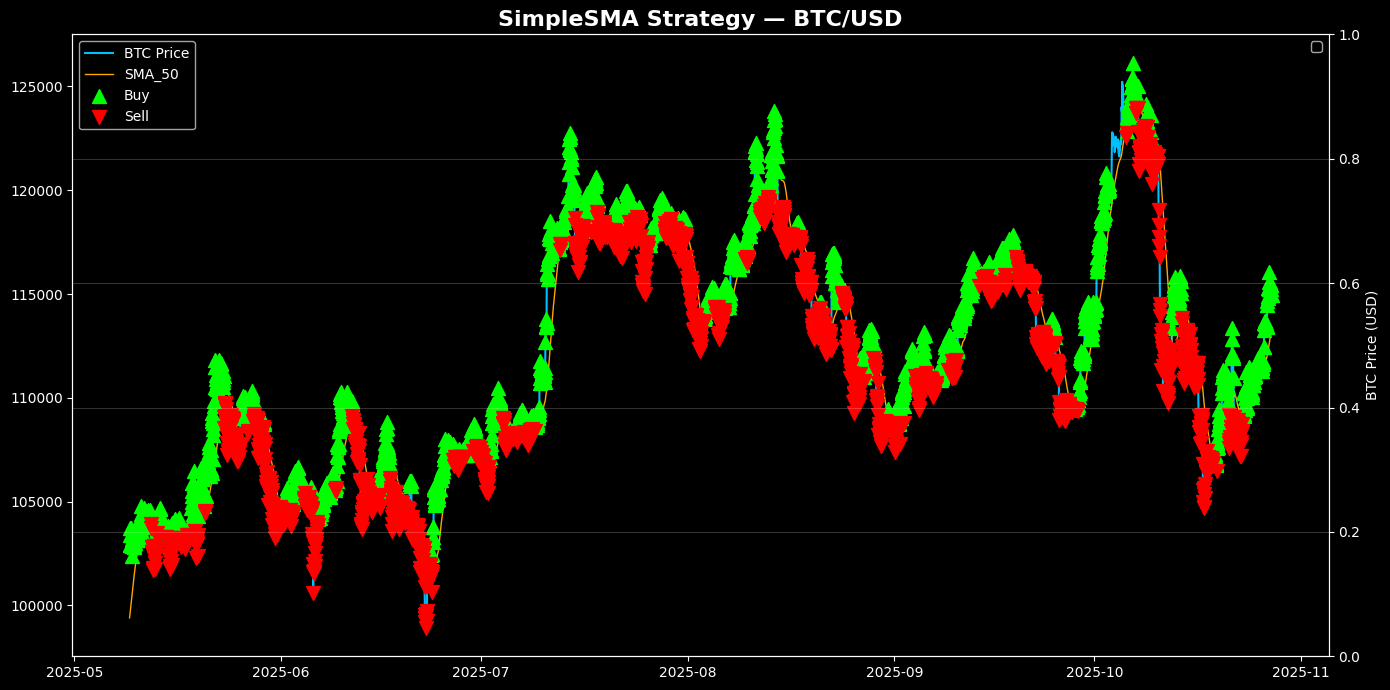

/tmp/ipython-input-1865169091.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc="upper right", fontsize=10)


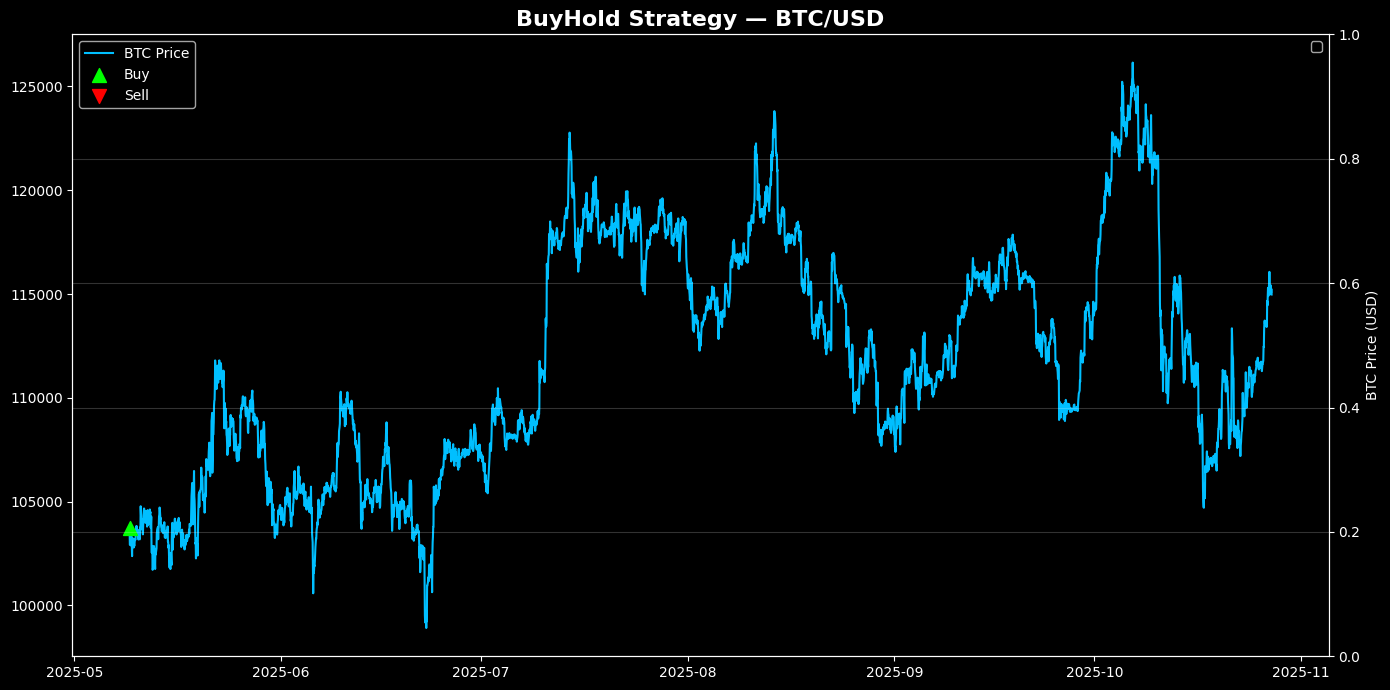

/tmp/ipython-input-1865169091.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc="upper right", fontsize=10)


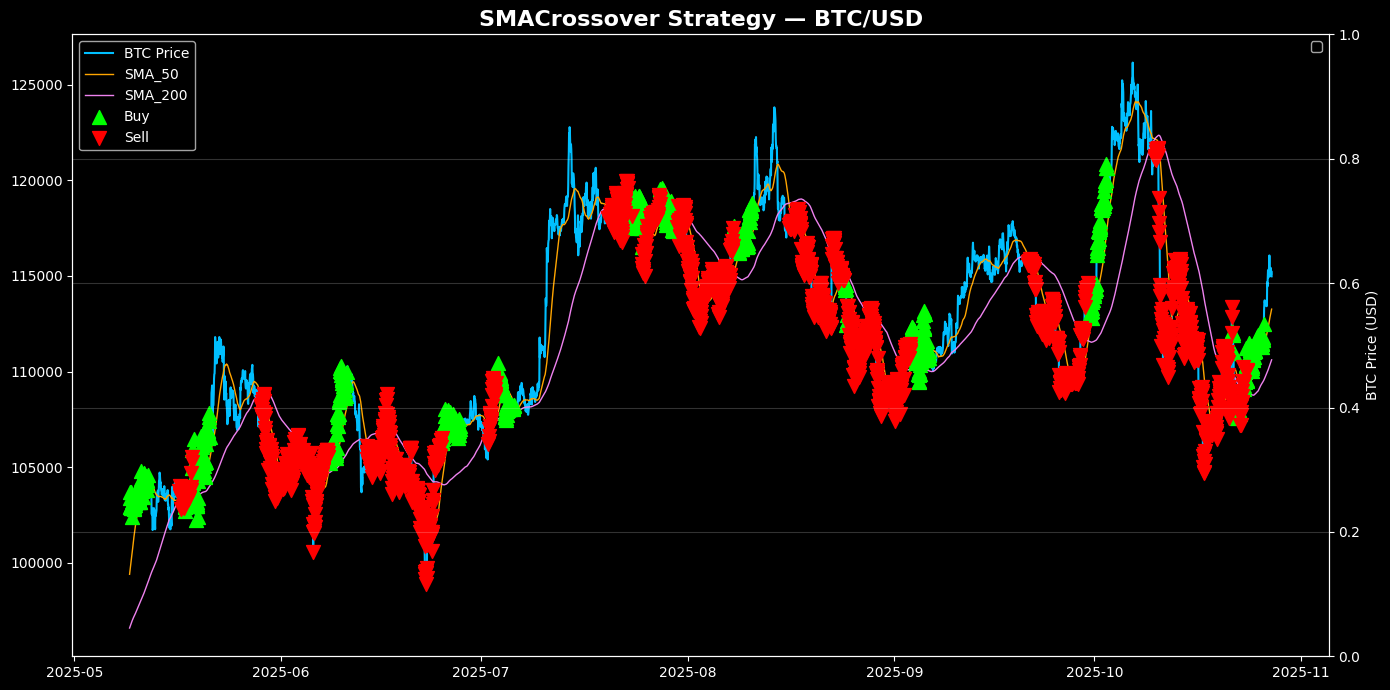

/tmp/ipython-input-1865169091.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc="upper right", fontsize=10)


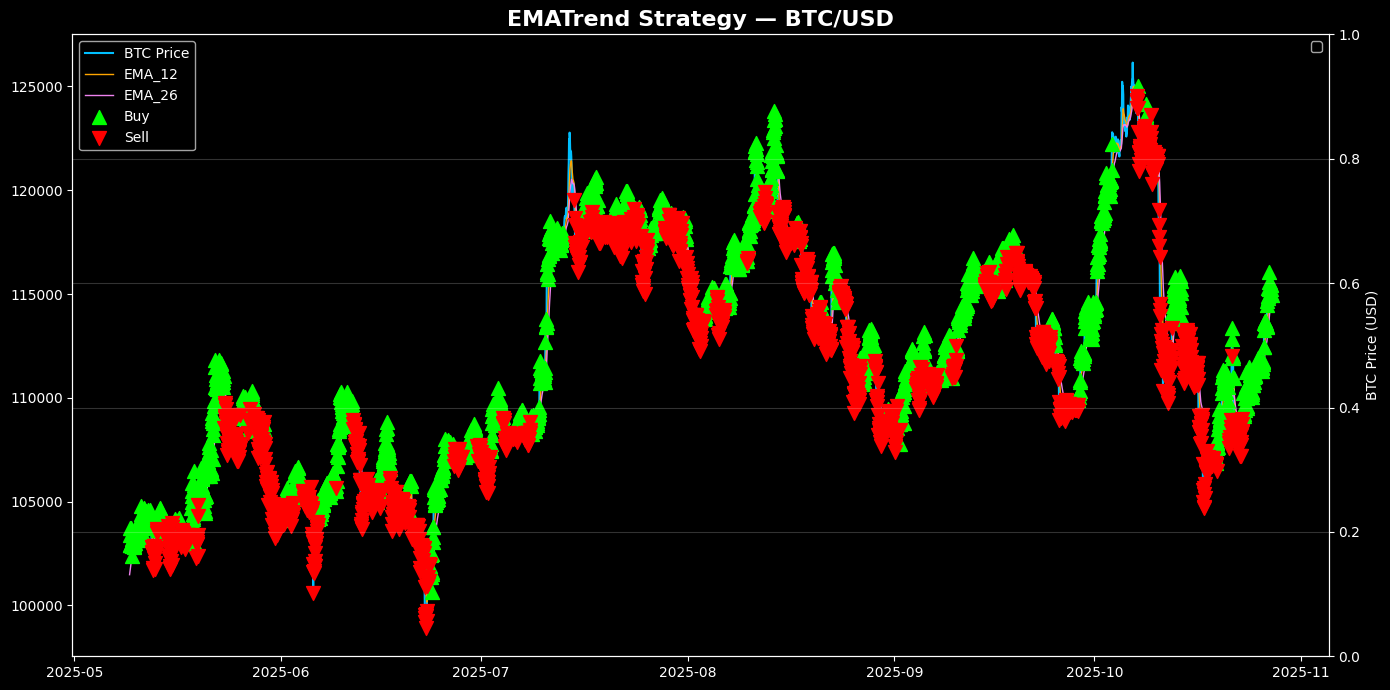

/tmp/ipython-input-1865169091.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc="upper right", fontsize=10)


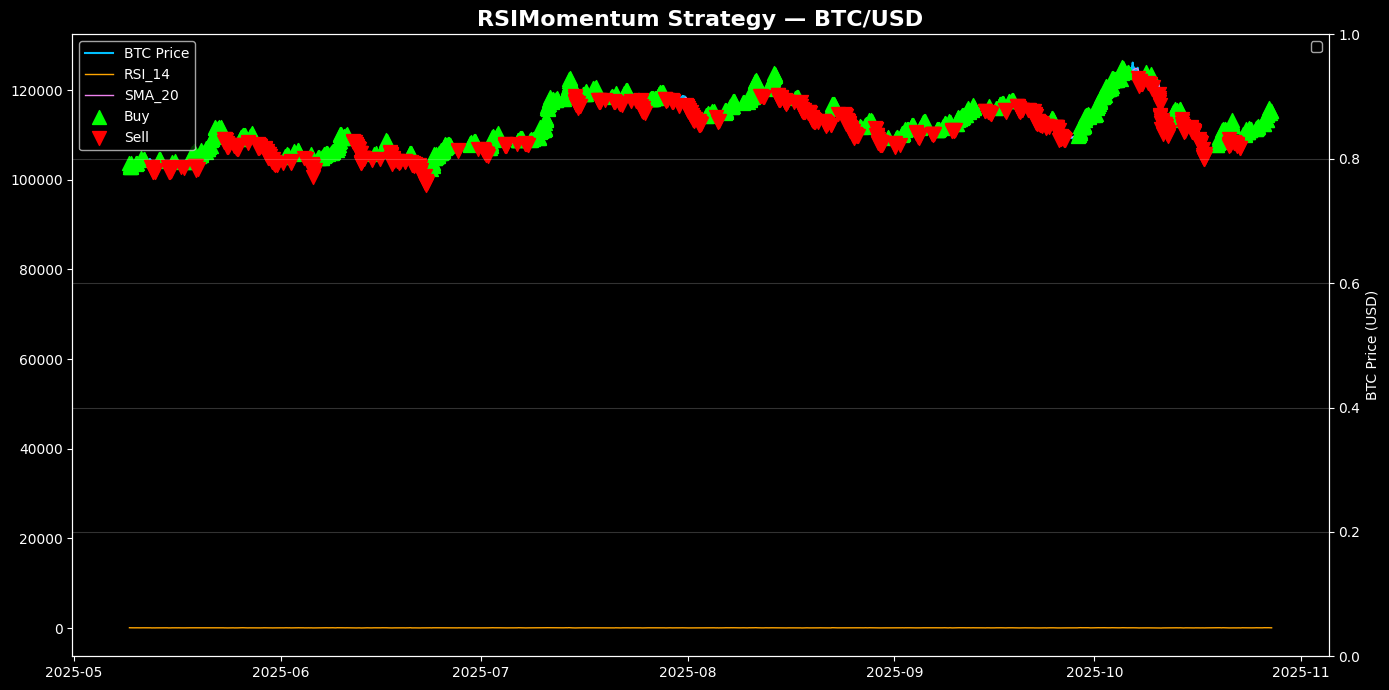

/tmp/ipython-input-1865169091.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc="upper right", fontsize=10)


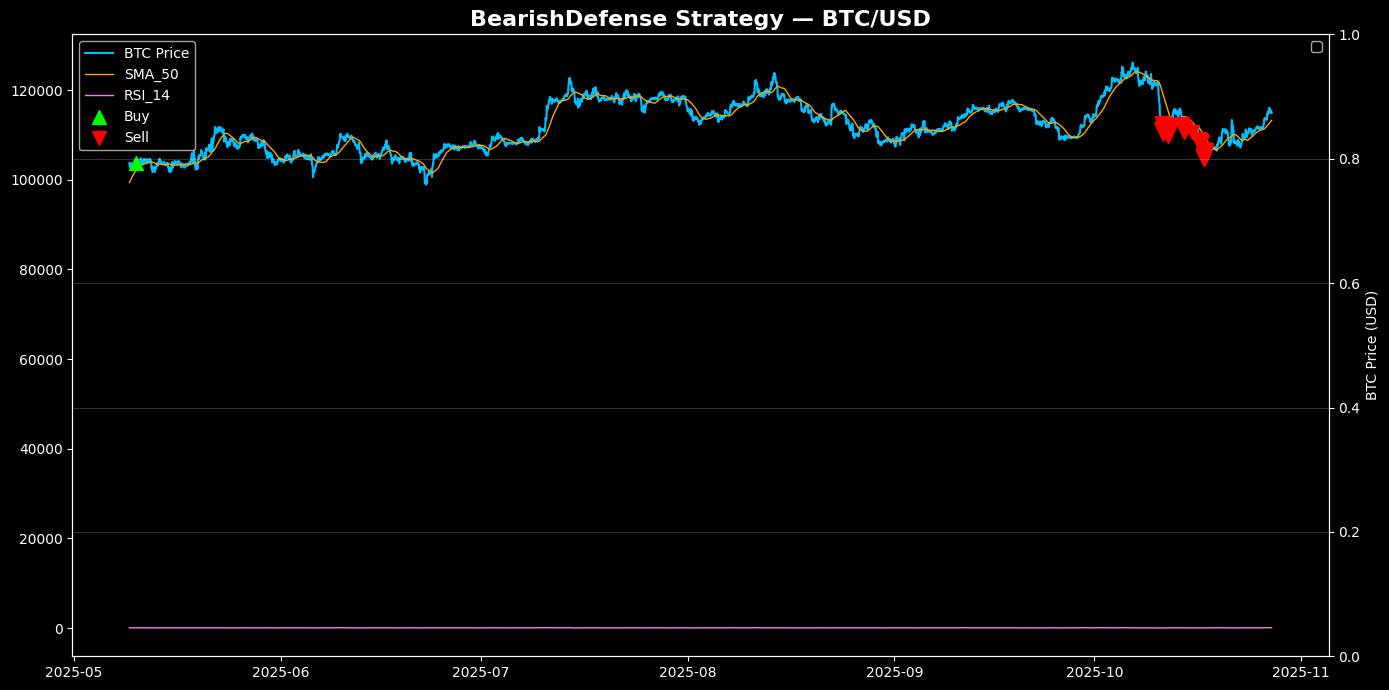

In [40]:
plot_strategy(df, transactions_df, "SimpleSMA")
plot_strategy(df, transactions_df, "BuyHold")
plot_strategy(df, transactions_df, "SMACrossover")
plot_strategy(df, transactions_df, "EMATrend")
plot_strategy(df, transactions_df, "RSIMomentum")
plot_strategy(df, transactions_df, "BearishDefense")


In [41]:
import pandas as pd

def summarize_strategy_performance(transactions_df, df, initial_cash=100000):
    """
    Creates and prints a summary performance table for all strategies.
    """

    strategies = transactions_df["Strategy"].unique()
    summary_data = []

    for strat in strategies:
        strat_tx = transactions_df[transactions_df["Strategy"] == strat]

        if strat_tx.empty:
            continue

        # Get final cash & BTC holdings from last transaction
        last_tx = strat_tx.iloc[-1]
        cash_left = last_tx.get("Cash_Left", 0.0)
        btc_holdings = last_tx.get("BTC_Holdings", 0.0)
        last_price = df["Close"].iloc[-1]

        final_value = cash_left + btc_holdings * last_price
        returns = ((final_value - initial_cash) / initial_cash) * 100
        trades = len(strat_tx)

        summary_data.append({
            "Strategy": strat,
            "Initial Value ($)": f"${initial_cash:,.0f}",
            "Final Value ($)": f"${final_value:,.0f}",
            "Returns (%)": f"{returns:+.1f}%",
            "Trades": trades
        })

    # Convert to DataFrame
    summary_df = pd.DataFrame(summary_data)

    # Sort by Returns descending
    summary_df = summary_df.sort_values(by="Returns (%)", ascending=False)

    print("\n🏆 FINAL PERFORMANCE COMPARISON")
    print("=" * 60)
    print(f"{'Strategy':<15}{'Initial Value':>15}{'Final Value':>15}{'Returns':>12}{'Trades':>10}")
    print("-" * 60)

    for _, row in summary_df.iterrows():
        print(f"{row['Strategy']:<15}{row['Initial Value ($)']:>15}{row['Final Value ($)']:>15}"
              f"{row['Returns (%)']:>12}{row['Trades']:>10}")

    print("=" * 60)

    return summary_df


# --- Run summary ---
summary_df = summarize_strategy_performance(transactions_df, df, initial_cash=100000)



🏆 FINAL PERFORMANCE COMPARISON
Strategy         Initial Value    Final Value     Returns    Trades
------------------------------------------------------------
BearishDefense        $100,000       $107,706       +7.7%        70
SimpleSMA             $100,000       $107,560       +7.6%      4051
RSIMomentum           $100,000       $104,778       +4.8%      1597
SMACrossover          $100,000       $121,638      +21.6%      2617
BuyHold               $100,000       $110,846      +10.8%         1
EMATrend              $100,000       $110,751      +10.8%      3983
